In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from descartes import PolygonPatch

In [72]:
# dataset
# https://www.kaggle.com/zynicide/wine-reviews#winemag-data-130k-v2.csv
# learn
# https://gramener.com/flags/?Distinct-Colors=3&Red=30-40%25&Blue=30-40%25&Yellow=30-40%25&show=flags
# example
# https://www.winemag.com/buying-guide/quinta-avidagos-2011-avidagos-red-douro/

In [73]:
df = pd.read_csv('winemag-data-cleaned.csv')
df.describe()

,Unnamed: 0,points,price
count,120802.000000,120802.000000,120802.000000
mean,64924.060322,88.179939,28.866085
std,37502.826030,2.894116,14.693529
min,0.000000,80.000000,4.000000
25%,32379.250000,86.000000,17.000000
50%,64933.500000,88.000000,25.000000
75%,97378.750000,90.000000,36.000000
max,129970.000000,99.000000,72.000000


In [74]:
df.isnull().any()

Unnamed: 0               False
country                  False
description              False
designation               True
points                   False
price                    False
province                  True
region_1                  True
region_2                  True
taster_name               True
taster_twitter_handle     True
title                    False
variety                  False
winery                   False
dtype: bool

## What are the worldwide wine ratings based on the reviewer's points?

# About the Scores
Ratings reflect what our editors felt about a particular product. Beyond the rating, we encourage you to read the accompanying tasting note to learn about a product’s special characteristics.

- 98–100 Classic      The pinnacle of quality.
- 94–97 Superb        A great achievement.
- 90–93 Excellent     Highly recommended.
- 87–89 Very Good     Often good value; well recommended.
- 83–86 Good          Suitable for everyday consumption; often good value.
- 80–82 Acceptable    Can be employed in casual, less-critical circumstances.

In [75]:
score6 = df[(df['points']>=80) & (df['points']<=82)]
score5 = df[(df['points']>=83) & (df['points']<=86)]
score4 = df[(df['points']>=87) & (df['points']<=89)]
score3 = df[(df['points']>=90) & (df['points']<=93)]
score2 = df[(df['points']>=94) & (df['points']<=97)]
score1 = df[(df['points']>=98) & (df['points']<=100)]
score = {
    'score6':{'totalscore': len(score6), 'countries':score6.country.unique(),'label':'Acceptable','range_value':'80–82'},
    'score5':{'totalscore': len(score5), 'countries':score5.country.unique(),'label':'Good','range_value':'83–86'},
    'score4':{'totalscore': len(score4), 'countries':score4.country.unique(),'label':'Very Good','range_value':'87–89'},
    'score3':{'totalscore': len(score3), 'countries':score3.country.unique(),'label':'Excellent','range_value':'90–93'},
    'score2':{'totalscore': len(score2), 'countries':score2.country.unique(),'label':'Superb','range_value':'94–97'},
    'score1':{'totalscore': len(score1), 'countries':score1.country.unique(),'label':'Classic','range_value':'98–100'}
}

In [76]:
score_df = pd.DataFrame(score).T
score_df['score_name'] = score_df.index
score_df.index = np.arange(len(score_df))
score_df['score'] = score_df['label'].apply(lambda x: '{}: '.format(x)) + score_df['range_value']
score_df

,totalscore,countries,label,range_value,score_name,score
0,2908,"[France, Spain, US, Chile, Portugal, Italy, Ar...",Acceptable,80–82,score6,Acceptable: 80–82
1,31334,"[US, France, Italy, Chile, Germany, Australia,...",Good,83–86,score5,Good: 83–86
2,45162,"[Italy, Portugal, US, Spain, France, Germany, ...",Very Good,87–89,score4,Very Good: 87–89
3,37951,"[Italy, US, Australia, South Africa, France, G...",Excellent,90–93,score3,Excellent: 90–93
4,3424,"[US, Germany, Italy, Australia, Portugal, Fran...",Superb,94–97,score2,Superb: 94–97
5,23,"[US, Italy, France, Austria]",Classic,98–100,score1,Classic: 98–100


In [77]:
# seaborn barplot changing the width
def change_width(ax, new_value) :
#     print(patch.get_width())
    for patch in ax.patches :
#         print(patch.get_x())
        current_width = patch.get_width()
        diff = current_width - new_value
        # we change the bar width
        patch.set_width(new_value)
        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

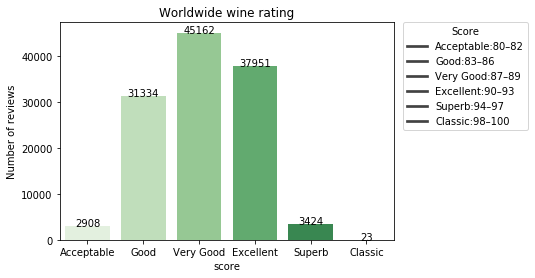

In [78]:
ax = sns.barplot(x="label", y="totalscore", data=score_df, palette="Greens")
# ax.set_ylim((0,200));
for index, row in score_df.iterrows():
    ax.text(row.name,row.totalscore, row.totalscore, color='black', ha="center")
ax.set_title('Worldwide wine rating')
ax.set(xlabel='score', ylabel='Number of reviews')
plt.legend(title='Score', loc='upper right',
           labels=score_df['label'].apply(lambda x : '{}:'.format(x))+ score_df['range_value'],
           bbox_to_anchor=(1.4, 1), borderaxespad=0.)
# change_width(ax, 1)
plt.show()

#### The number of points WineEnthusiast rated the wine on a scale of 1-100 (though they say they only post reviews for wines that score >=80)

In [79]:
worldwide_wineInsight = ['classic the pinnacle of quality.','superb a great achievement.','excellent highly recommended.','very good Often good value well recommended.','good suitable for everyday consumption, often good value.','acceptable can be employed in casual, less-critical circumstances.']
worldwide_wineInsight.reverse()

In [85]:
score_df['insight'] = worldwide_wineInsight

In [86]:
score_df['insight']

0    acceptable can be employed in casual, less-cri...
1    good suitable for everyday consumption, often ...
2         very good Often good value well recommended.
3                        excellent highly recommended.
4                          superb a great achievement.
5                     classic the pinnacle of quality.
Name: insight, dtype: object

In [87]:
# to color a specific country
def plotCountryPatch( axes, country_name, fcolor ):
    # plot a country on the provided axes
    nami = world[world.name == country_name]
    namigm = nami.__geo_interface__['features']  # geopandas's geo_interface
    namig0 = {'type': namigm[0]['geometry']['type'], \
              'coordinates': namigm[0]['geometry']['coordinates']}
    axes.add_patch(PolygonPatch( namig0, fc=fcolor, ec="black", alpha=0.85, zorder=2 ))

In [ ]:
# countries that falls 

In [88]:
mapping = {'US':'United States of America','Czech Republic':'Czechia','England':'United Kingdom'}

Bosnia and Herzegovina
Bosnia and Herzegovina


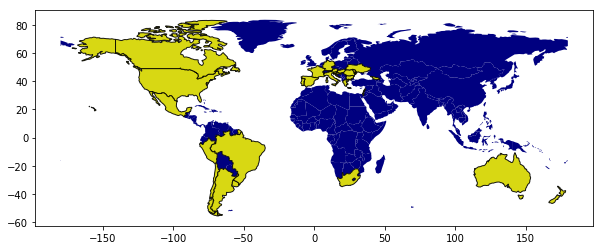

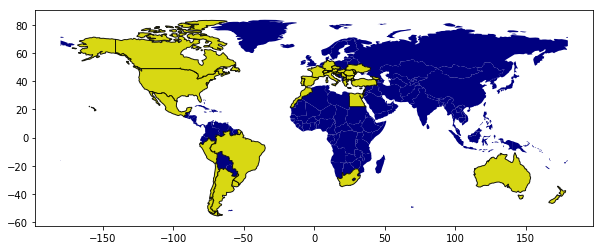

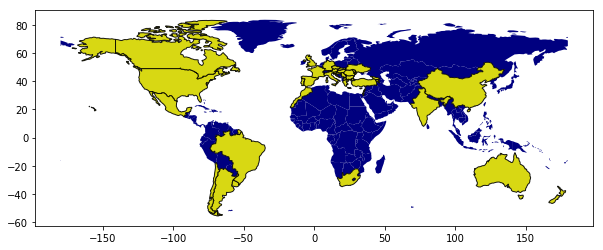

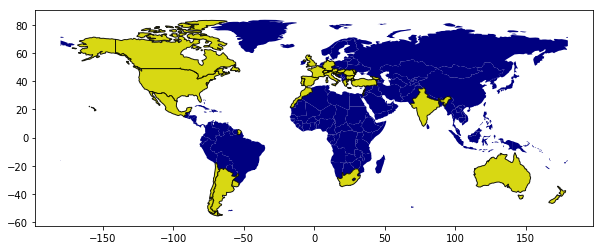

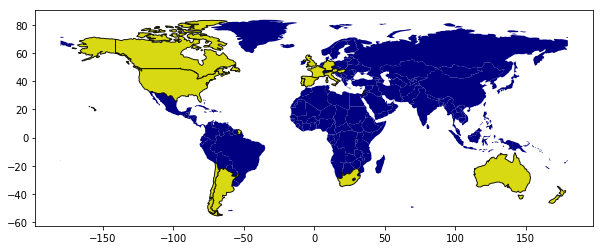

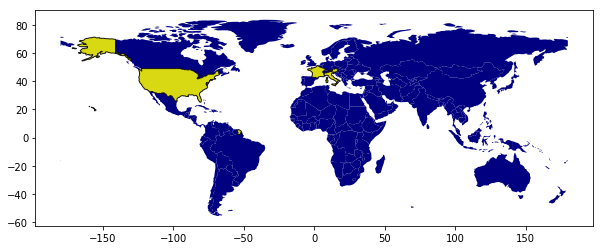

In [89]:
for score_ in score_df.itertuples():
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    world = world[(world.pop_est>0) & (world.name!="Antarctica")]
    world['gdp_per_cap'] = world.gdp_md_est / world.pop_est
    ax2 = world.plot(figsize=(10,10),color='navy')
    for countries in score_.countries:
        if countries in mapping:
            countries = mapping[countries]
        if countries != 'nan':
            try:
                plotCountryPatch(ax2, countries,'yellow')
            except:
                print(countries)
    

In [90]:
score_df['countries'].apply(lambda x: '{} countries are '.format(len(x))) + score_df['insight']

0    28 countries are acceptable can be employed in...
1    37 countries are good suitable for everyday co...
2    40 countries are very good Often good value we...
3       31 countries are excellent highly recommended.
4         16 countries are superb a great achievement.
5     4 countries are classic the pinnacle of quality.
dtype: object

In [359]:
# country that the wine is from in this review
# Top 5 countires from where we have this review 

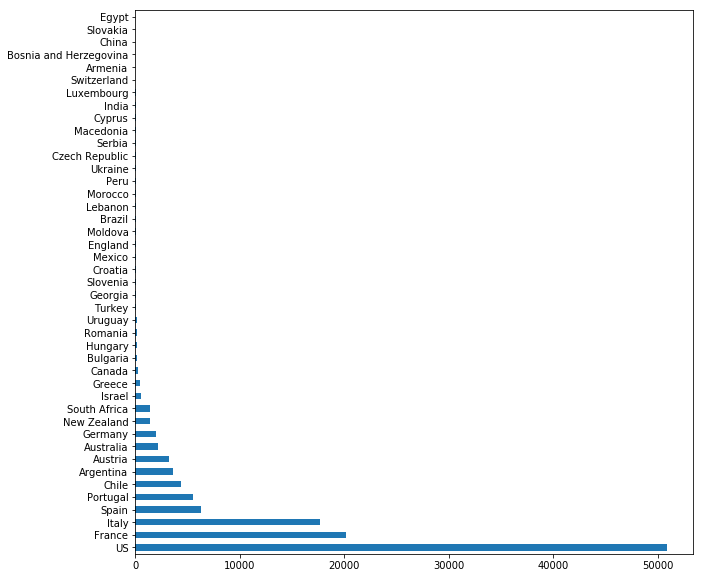

In [368]:
df['country'].value_counts().plot(kind='barh', figsize=(10,10))

In [306]:
country_group = df['country'].value_counts()
country_group = country_group.to_frame()
country_group.index.name = 'country_name'
country_group = country_group.reset_index()
country_group = country_group.rename(columns={'country':'total_reviews'})
country_group['total_reviews_perc'] = country_group['total_reviews'].apply(lambda x : 100*(x/country_group['total_reviews'].sum()))
pointgroup  = df.groupby('country', as_index=False).agg({'points': 'mean'})
pointgroup = pointgroup.rename(columns={'country':'country_name'})
reviews_details = pd.merge(pointgroup,country_group)
reviews_details = reviews_details.sort_values('total_reviews_perc', ascending=False)

## Which are the top 5 countries where most of the reviews are from ?

In [344]:
reviews_details_top_5 = reviews_details[reviews_details['total_reviews_perc']>4]
reviews_details_top_5_other = reviews_details[reviews_details['total_reviews_perc']<=4]
temp_other = pd.DataFrame({'country_name':['others'],
              'points':[reviews_details_top_5_other['points'].mean()],
              'total_reviews':[reviews_details_top_5_other['total_reviews'].sum()],
              'total_reviews_perc':[reviews_details_top_5_other['total_reviews_perc'].sum()]
             })
reviews_details_top_5 = pd.concat([reviews_details_top_5,temp_other])

In [345]:
reviews_details_top_5

,country_name,points,total_reviews,total_reviews_perc
40,US,88.331151,50859,42.101124
15,France,88.478972,20164,16.691777
22,Italy,88.233362,17625,14.589990
37,Spain,87.026699,6255,5.177894
31,Portugal,88.056559,5481,4.537177
0,others,87.492669,20418,16.902038


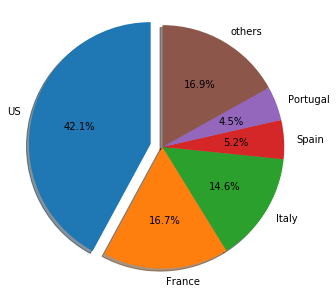

In [358]:
fig1, ax1 = plt.subplots(figsize=(5,5))
explode = (0.1,0,0,0,0,0)
ax1.pie(reviews_details_top_5['total_reviews'],labels=reviews_details_top_5['country_name'],autopct='%1.1f%%',shadow=True,startangle=90,explode=explode)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [13]:
df['variety'].nunique()

697

## A total of 697 variety of the wine is tested and reviewed.

## which all countries we found similar variety of wines?
## which is the most common wine variety in the world?

In [129]:
variety_details = df.groupby('variety', as_index=False).agg({'country': 'nunique'}).sort_values(by='country', ascending=False)
variety_details['country_list'] = variety_details['variety'].apply(lambda x: list(df[df['variety']== x]['country'].unique()))
variety_details

,variety,country,country_list
468,Red Blend,33,"[US, Italy, Chile, Spain, South Africa, Argent..."
680,White Blend,33,"[Italy, France, South Africa, Greece, US, Hung..."
125,Chardonnay,30,"[US, France, Australia, Chile, South Africa, A..."
487,Rosé,28,"[Australia, France, US, Spain, Portugal, Italy..."
509,Sauvignon Blanc,26,"[US, New Zealand, Australia, Italy, Chile, Aus..."
...,...,...,...
263,Lambrusco Salamino,1,[Italy]
262,Lambrusco Grasparossa,1,[Italy]
261,Lambrusco,1,[Italy]
259,Kuntra,1,[Turkey]


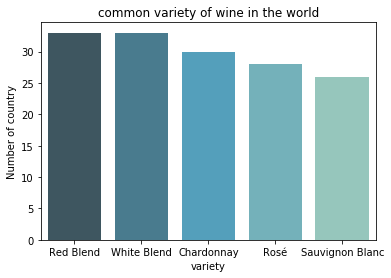

In [128]:
ax = sns.barplot(x="variety", y="country", data=variety_details.head(),palette="GnBu_d")
ax.set_title('common variety of wine in the world')
ax.set(xlabel='variety', ylabel='Number of country')
plt.show()

## So Red Blend, White Blend is the most common variety of wine in the world
## Red blend and white blend are the top variety of wines in the world  

In [130]:
# which cheese are very import in wine testing 


In [ ]:
# age and locality 
# winery
# df.groupby('winery',as_index=False).agg({'country':'nunique'})

# winery analysis

## from which country how many varieties are reviewed?

### from India how many varieties are reviewed?

In [144]:
df.groupby('country',as_index=False).agg({'variety':'nunique'}).sort_values(by='variety',ascending=False)

,country,variety
40,US,253
22,Italy,186
15,France,148
37,Spain,124
31,Portugal,89
0,Argentina,67
2,Australia,66
8,Chile,62
3,Austria,56
36,South Africa,55


In [147]:
df[df['country']=='India']['variety'].nunique()

3

In [160]:
(df[df['country']=='India']).groupby('variety', as_index=False).agg({'points': 'mean'})

,variety,points
0,Chenin Blanc,89.0
1,Sauvignon Blanc,89.5
2,Shiraz,91.5


In [166]:
india_wine_price = (df[df['country']=='India']).groupby('variety',as_index=False).agg({'price':'mean'})
india_wine_price

,variety,price
0,Chenin Blanc,10.666667
1,Sauvignon Blanc,12.000000
2,Shiraz,16.000000


<BarContainer object of 3 artists>

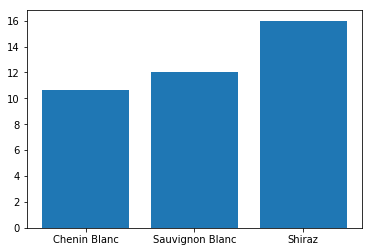

In [167]:
plt.bar(india_wine_price['variety'],india_wine_price['price'])

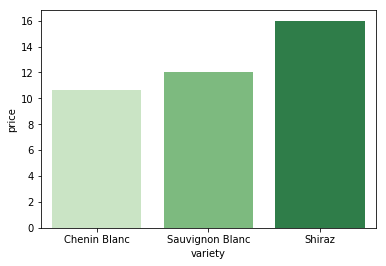

In [169]:
sns.barplot(x='variety',y='price',data=india_wine_price,palette='Greens')


In [174]:
df.groupby('variety',as_index=False).agg({'points':'mean'}).sort_values('points',ascending=False)

,variety,points
603,Tinta del Pais,95.000000
207,Gelber Traminer,95.000000
528,Sercial,94.000000
475,Riesling-Chardonnay,94.000000
68,Bual,93.200000
...,...,...
538,Shiraz-Tempranillo,82.000000
417,Picapoll,82.000000
3,Aidani,82.000000
4,Airen,81.666667
